In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import scipy
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils

import bilby


In [2]:
torch.cuda.is_available()

True

In [44]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
h5filename = root_dir + 'gw_fd_8D_q25a8_2N5000_IMREOB_PHM3.h5'

Ngw = gwutils.get_gwfdh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

random_index = np.random.permutation(Ngw)
train_index = random_index[:Ntrain]
test_index = random_index[Ntrain:Ntrain+Ntest]
valid_index = random_index[-Nvalid:]

gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index)


In [3]:
gw_dataset.n_samples

1750

In [45]:
train_label = 'IMREOBPHM_q25a8fd_2N5000_32s8192Hz'
# IMREOBPHM_q25a8fd_2N5000
# IMREOBPHM_q25a8fd_2N5000_16s4096Hz
# IMREOBPHM_q25a8fd_2N5000_32s8192Hz
# IMRPv2EOBv4P_q7a5fd_2N2000
gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [46]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.6, b=0.8), targets_getter=GetRandomIndcs(a=0.6, b=0.8), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [47]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [51]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname="/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/",
    device="cuda",
    lr=5e-4,
    decay_lr=10,
    seed=123,
    batch_size=2,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=50,
    **KWARGS
)




--- Training IMREOBPHM_q25a8fd_2N5000_32s8192Hz/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1    27341.9056    28829.9854     +  74.3430


      2    14694.9240    12112.2200     +  85.0357


      3    16128.4781    17034.1654        78.3567


      4    12347.8843    10310.2576     +  83.1671


      5     9229.9981    11939.0219        77.8873


      6     8372.2693    11287.3464        70.4232


      7     7526.4620     9992.9470     +  75.0095


      8     7258.2092     9817.0338     +  83.7321


      9     7006.9462    10641.3983        84.3656


     10     6777.2758    15621.1476        74.0754


     11     6319.6421    13229.2070        67.8699


     12     6023.8060     7137.9227     +  69.5438


     13     5873.5070     6723.8436     +  73.9008


     14     5523.9232     6153.2323     +  78.9619


     15     5195.5907     8697.2840        83.0910


     16     5072.3019     9051.9583        77.1555


     17     5001.5584     6186.5921        73.1368


     18     4696.5036     9204.5633        62.7250


     19     4501.3020     5376.7056     +  83.3301


     20     4256.4219     8209.3165        79.1977


     21     4061.2598     5624.1468        83.1090


     22     3947.6124     6518.4312        75.2897


     23     3773.5266     5101.3285     +  72.8718


     24     3757.9543     8889.5300        72.2269


     25     3390.8437     5043.8838     +  72.5498


     26     3337.2392     5534.3269        68.4252


     27     3140.0006     4252.6608     +  69.4461


     28     3183.1343     4590.6867        80.6271


     29     2809.7345     4392.0337        79.4708


     30     2826.3772     4096.9443     +  69.8007


     31     2531.6765     3709.7108     +  59.3965


     32     2482.1068     4230.7259        67.5120


     33     2414.4679     3767.2345        69.2770


     34     2229.9222     4087.8787        75.4823


     35     2274.6223     3319.5083     +  70.4386


     36     2039.3045     4000.3064        70.9562


     37     2087.6144     3716.0308        73.0907


     38     1929.1474     4745.0463        61.9170


     39     1826.9555     4071.1017        64.4626


     40     1806.0020     3258.2488     +  65.6165


     41     1753.1576     3283.5839        67.0997


     42     1622.8473     2787.8331     +  64.6833


     43     1553.9947     3242.8031        72.7768


     44     1580.0853     3628.0968        69.9285


     45     1528.0315     2870.9601        74.6156


     46     1467.6835     2902.2014        72.1453


     47     1374.0512     3048.6928        91.5830


     48     1307.8651     3185.6645        76.2844


     49     1279.8136     3024.7147        81.1374


     50     1196.7176     2804.0007        76.8494


IMREOBPHM_q25a8fd_2N5000_32s8192Hz/ConvCNP/run_0 | best epoch: 42 | train loss: 1196.7176 | valid loss: 2787.8331 | test log likelihood: -1755.5566


In [52]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

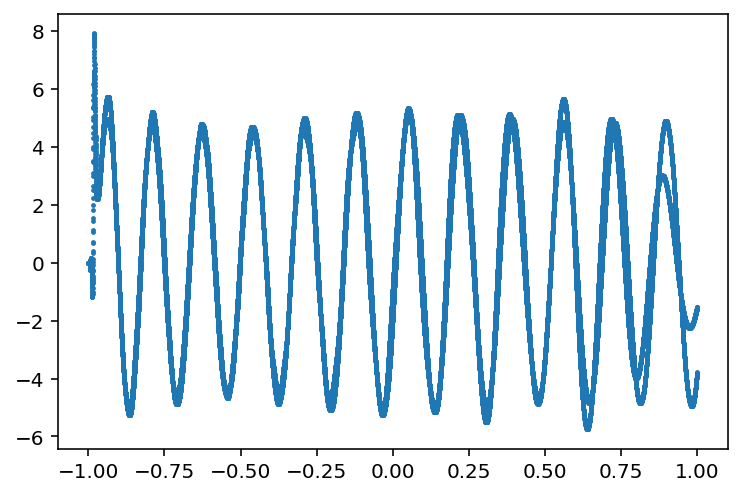

In [53]:
plt.scatter(gw_test_dataset[0][0].squeeze(), gw_test_dataset[0][1].squeeze(), s=2)

In [54]:
gw_test_dataset.waveform_models

array(['IMRPhenomXPHM', 'SEOBNRv4PHM'], dtype='<U13')

In [61]:
#look_approx = 'IMRPhenomPv2'
look_index = 1
chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomXPHM')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4PHM')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]




In [62]:
x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomXPHM', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4PHM', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [63]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)

In [64]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]


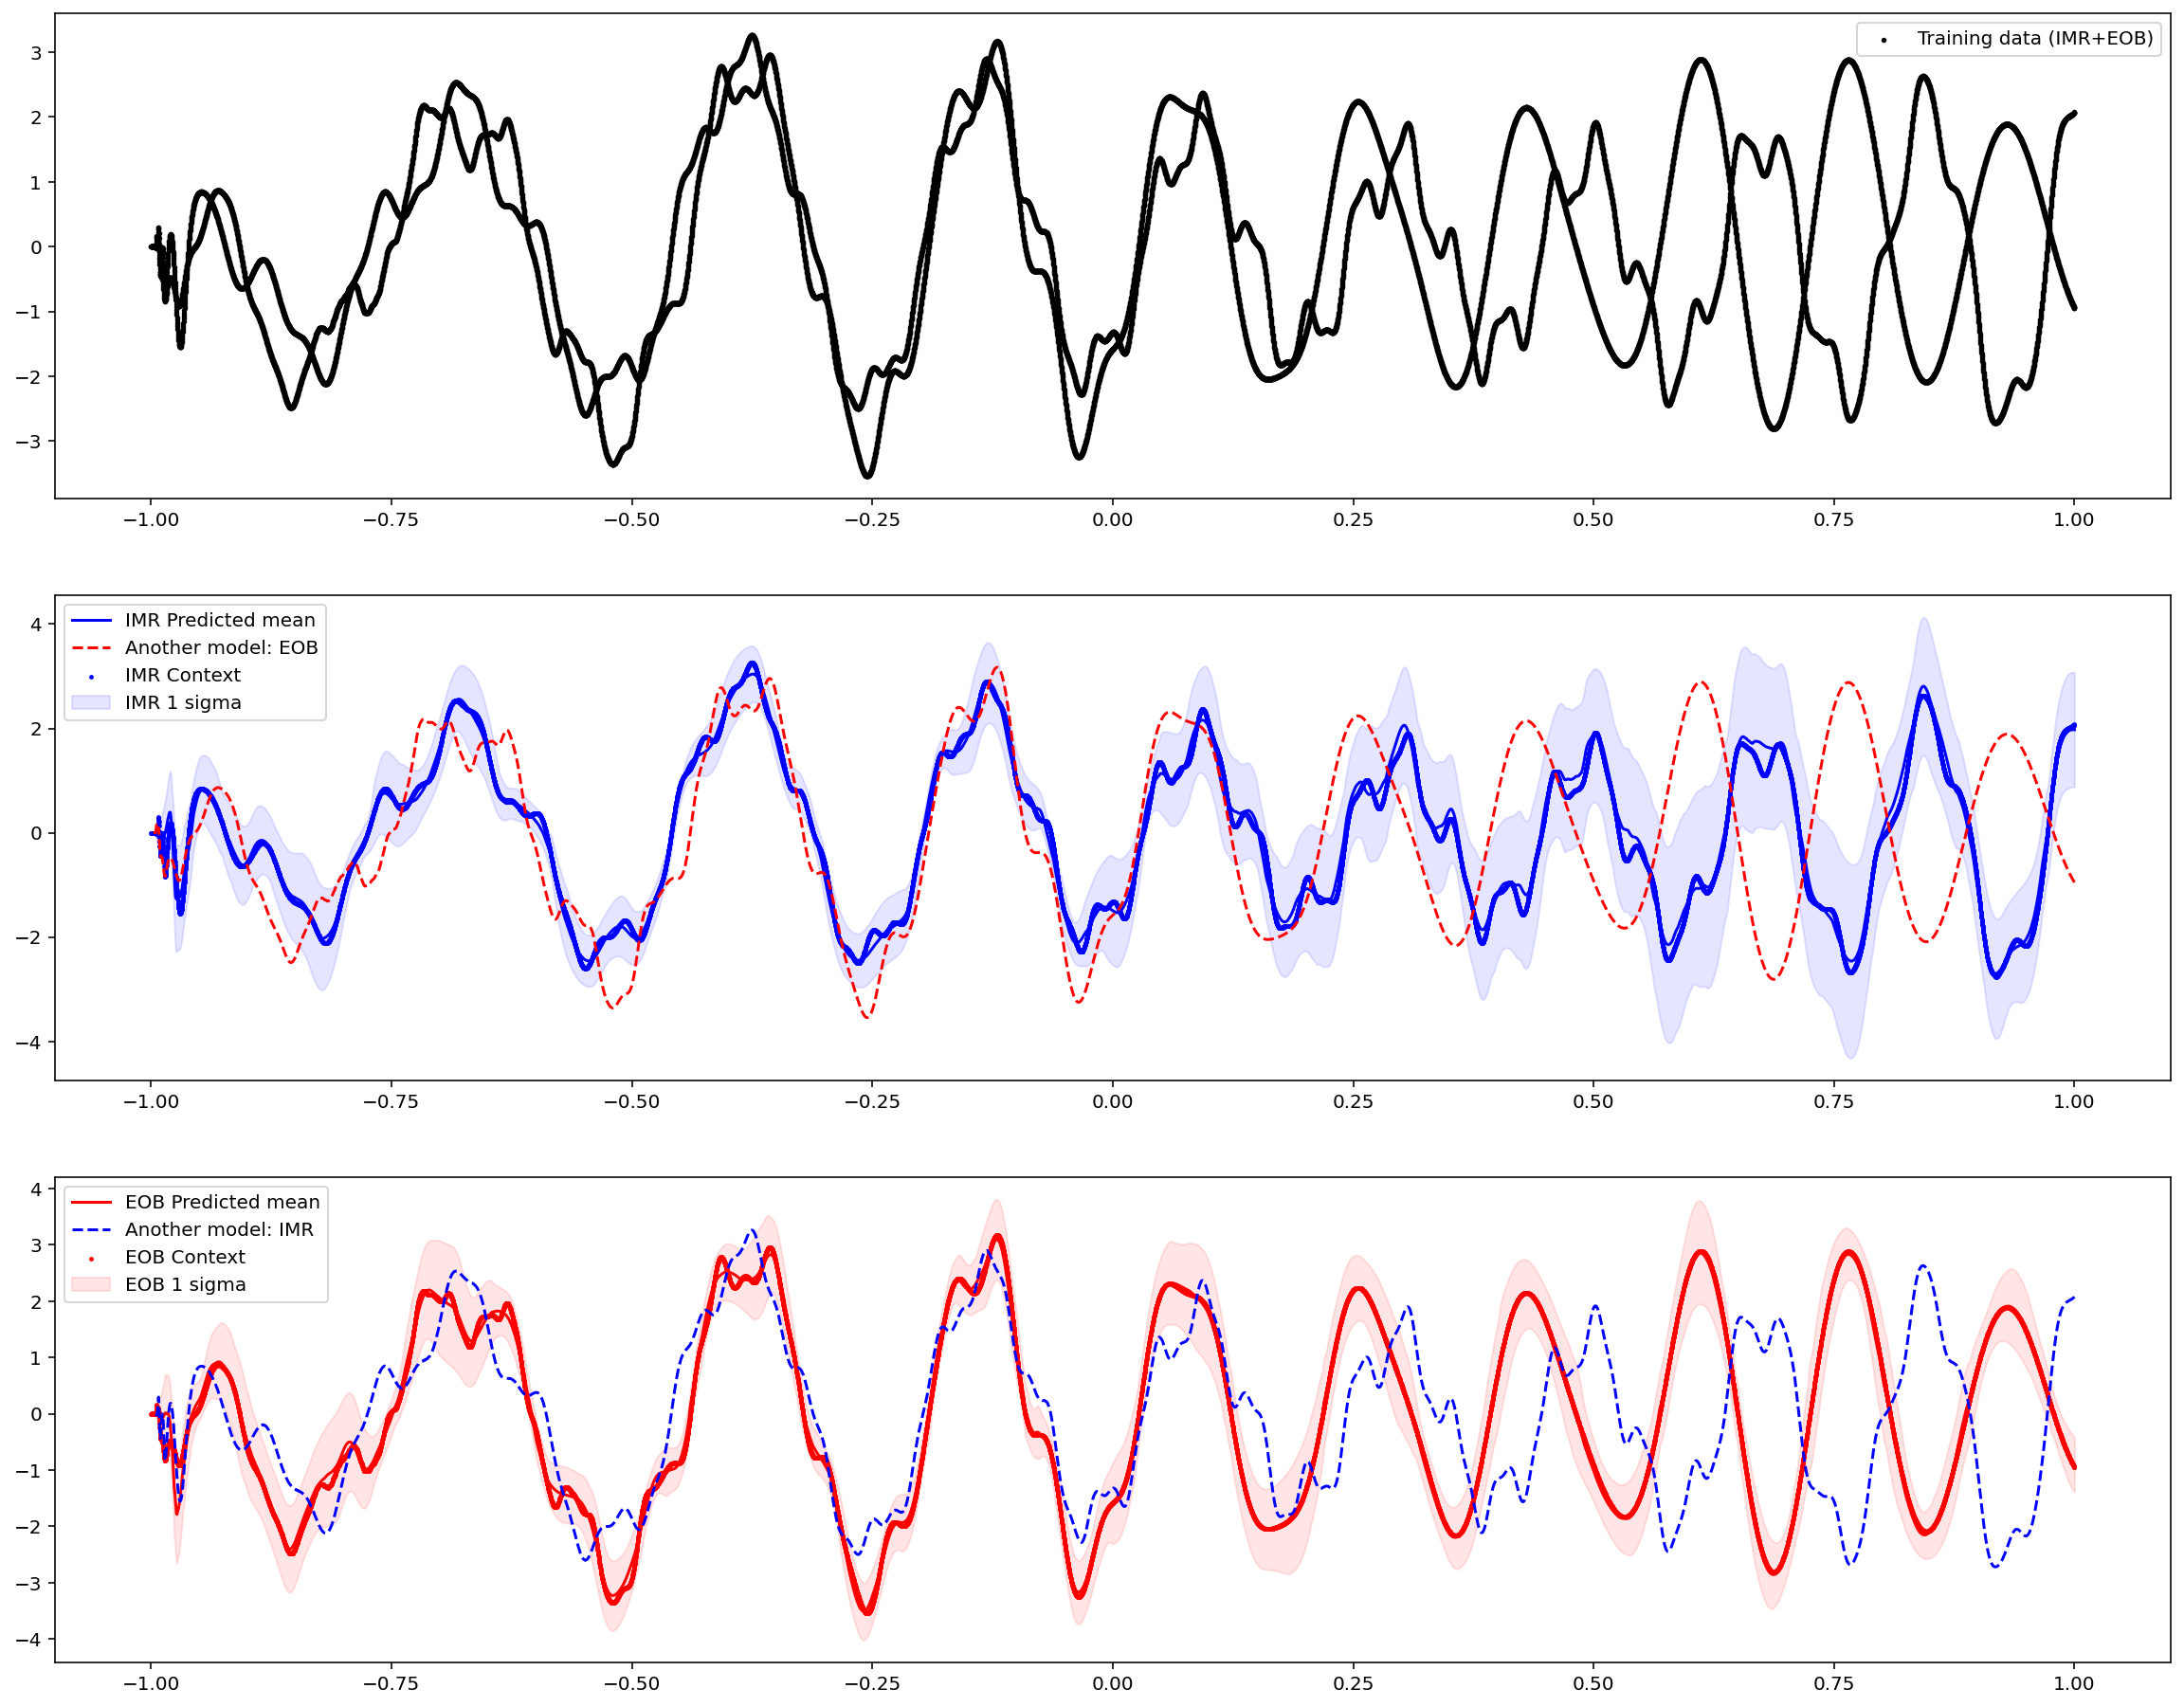

In [65]:
plt.figure(figsize=(20,16))
plt.subplot(3,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(3,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(3,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

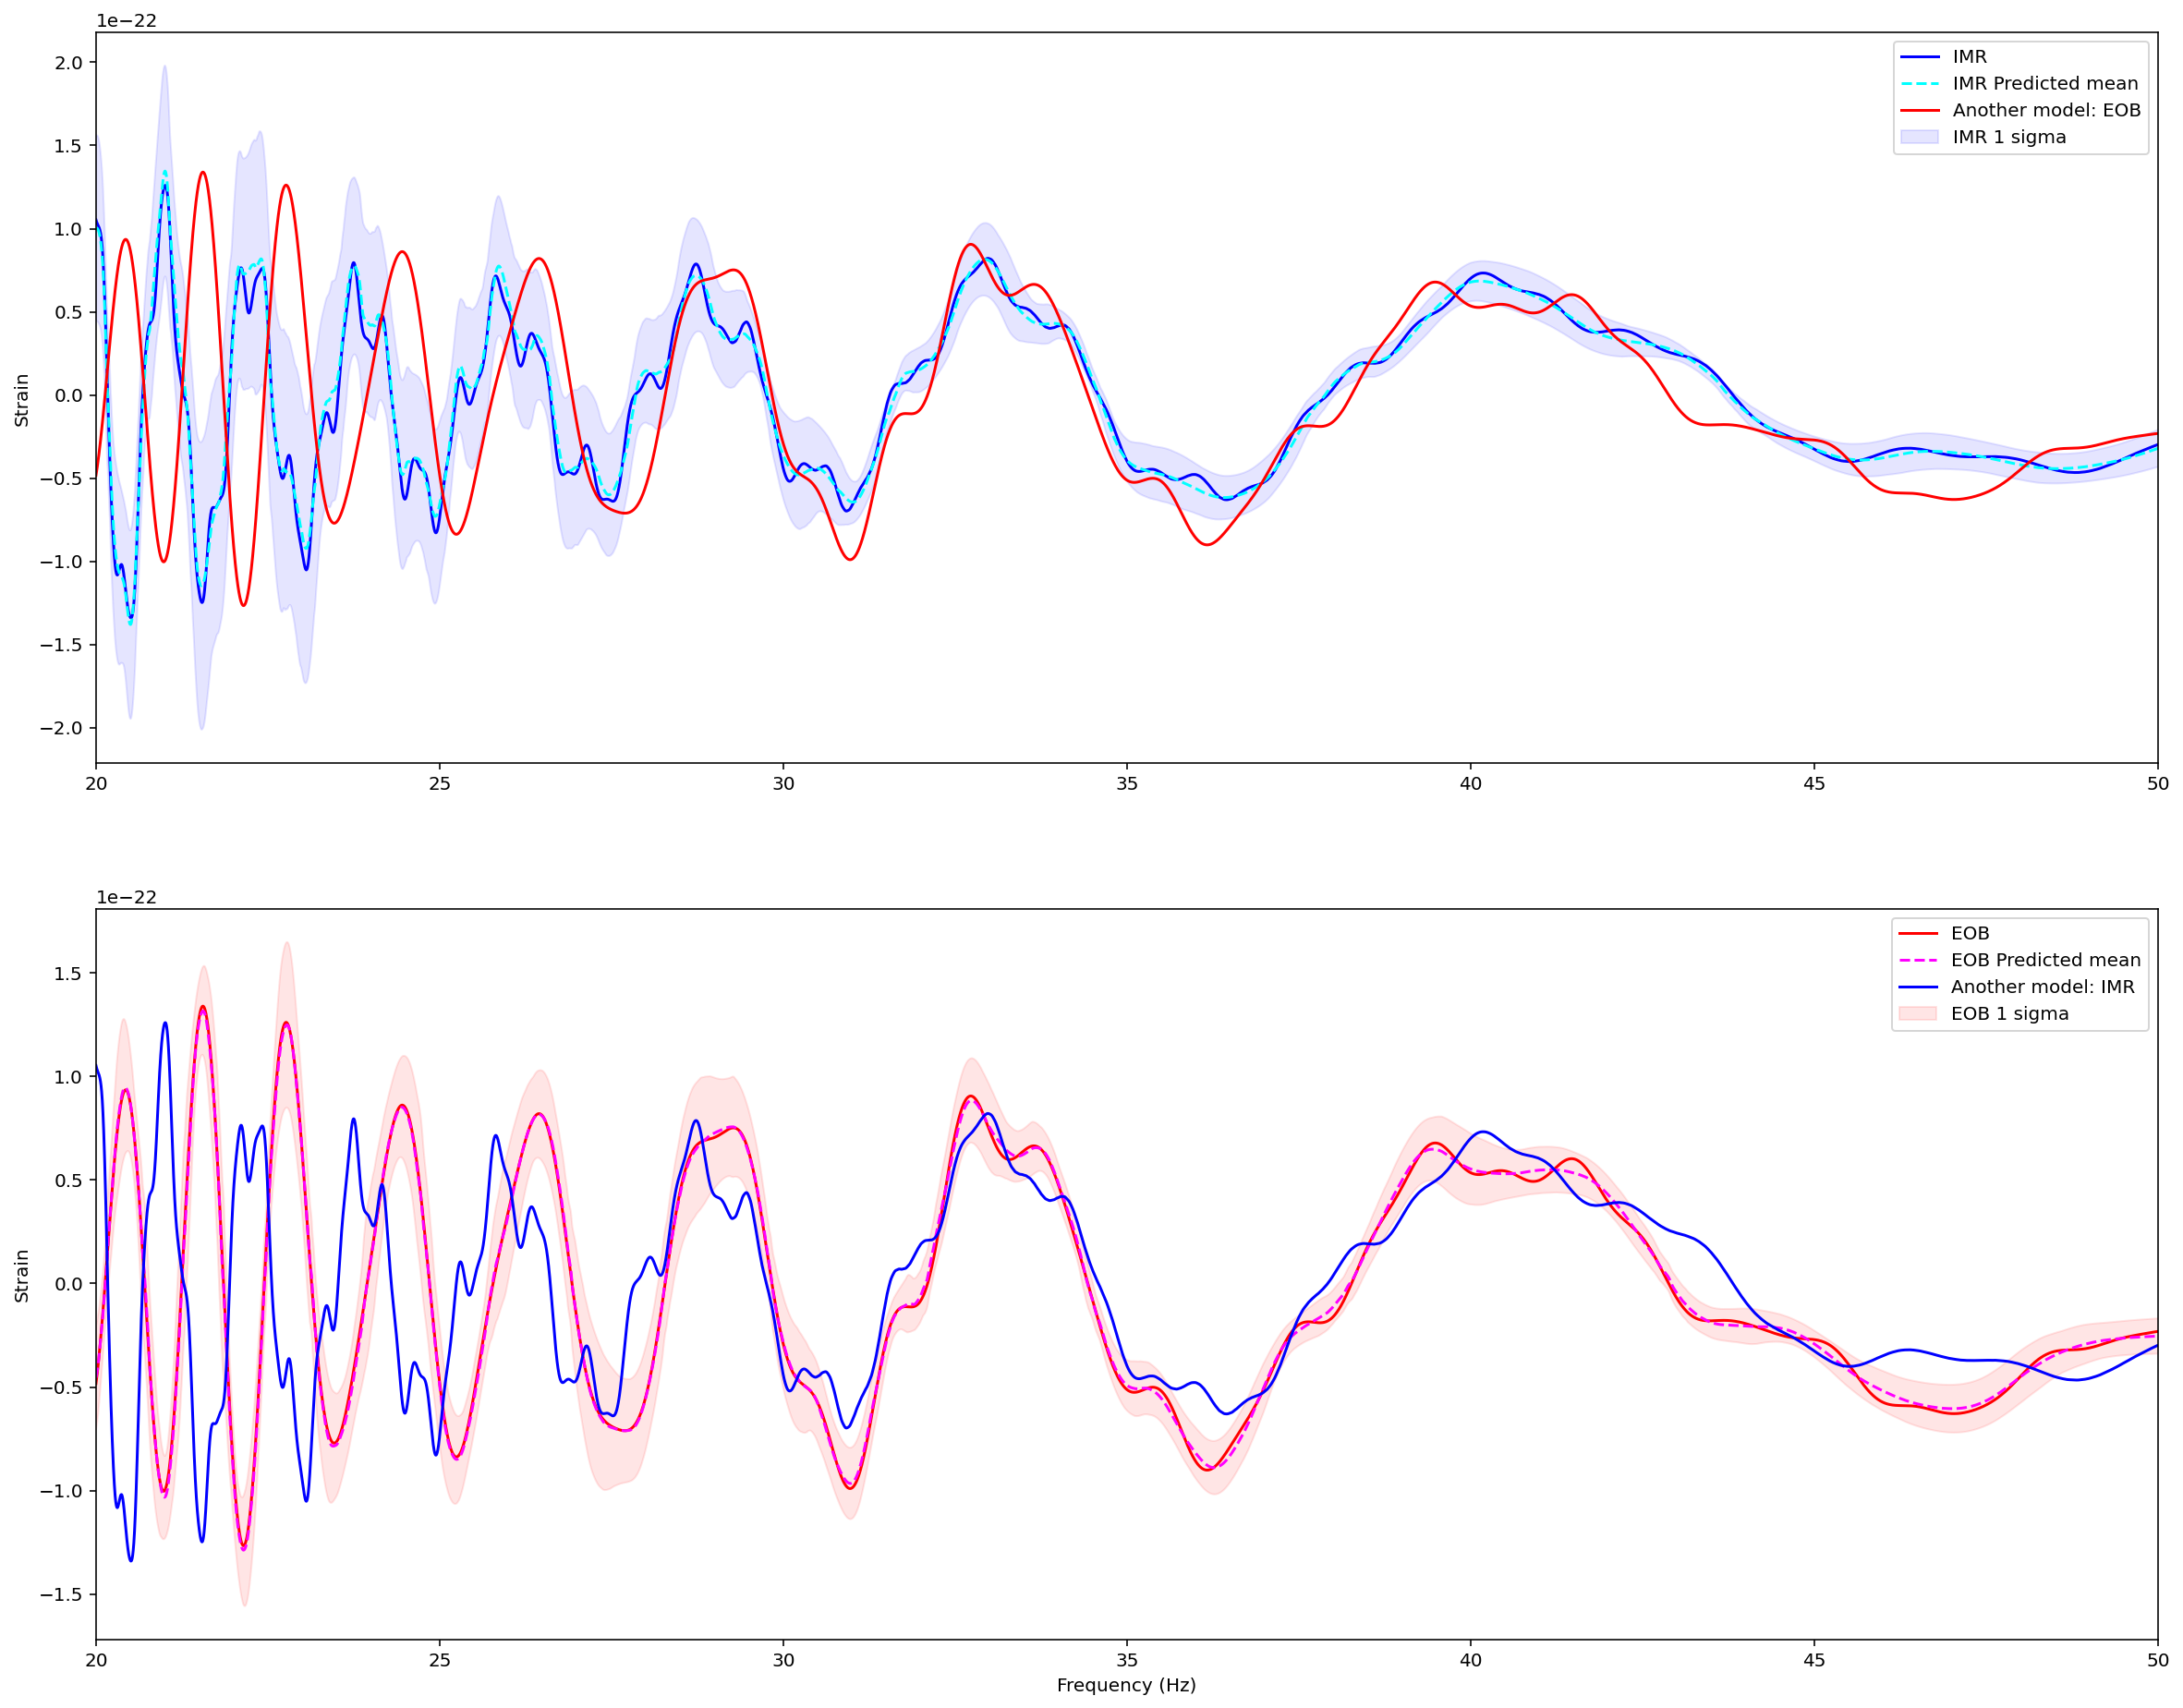

In [66]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 1

plt.subplot(2,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(2,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

In [36]:
def my_inner_product(hf1,hf2,det,flag):
    inner_prod_complex = bilby.gw.utils.noise_weighted_inner_product(
                            aa=hf1[det.strain_data.frequency_mask],
                            bb=hf2[det.strain_data.frequency_mask],
                            power_spectral_density=det.power_spectral_density_array[det.strain_data.frequency_mask],
                            duration=det.strain_data.duration)

    #inner_prod_complex = det.inner_product_2(hf1, hf2)
    if flag == "c":
        return inner_prod_complex
    elif flag == "r":
        return np.real(inner_prod_complex)
    else:
        raise("Wrong flag!")


def get_dtdphi_withift_zeropad(h1,h2,det):

    psd = det.power_spectral_density_array
    f_array = det.frequency_array
    
    X_of_f = h1*h2.conjugate()/psd
    add_zero = np.zeros(int(63*len(X_of_f)))
    X_of_f = np.append(X_of_f,add_zero)
    X_of_t = np.fft.ifft(X_of_f)
    
    timelength = 1/(f_array[1]-f_array[0])
    t = np.linspace(-timelength/2,timelength/2,len(X_of_t))
    X_shifted = np.roll(X_of_t,len(X_of_t)//2)

    jmax = np.argmax( abs(X_shifted) )
    deltat = t[jmax]
    phase1 = 2*np.pi*f_array*deltat
    
    freq_mask = det.strain_data.frequency_mask
    inner_product = my_inner_product(h1.conjugate(), h2.conjugate()*np.exp(1j*phase1), det, 'c')
    
    deltaphi = -np.angle(inner_product)
    #phase2 = deltaphi
    
    return deltat,deltaphi


def get_shifted_h2_zeropad(h1,h2,det):
    '''
    Return the h2*exp(-i*phase_shift), i.e. h2* exp -i*(2\pi f \Delta t + \Delta \phi)
    '''
    deltat,deltaphi = get_dtdphi_withift_zeropad(h1,h2,det)
    f_array = det.frequency_array
    exp_phase = np.exp(-1j*(2*np.pi*f_array*deltat + deltaphi) )
    return h2*exp_phase



def mismatch(h1, h2, det):
    h2_shifted = get_shifted_h2_zeropad(h1,h2,det)
    norm = (my_inner_product(h1,h1,det,'r')*my_inner_product(h2_shifted,h2_shifted,det,'r'))**0.5
    inner = my_inner_product(h1,h2_shifted,det,'r')

    return 1-inner/norm

In [37]:
'''
duration=32
f_lower=20
sampling_frequency=8192
'''

duration=16
f_lower=20
sampling_frequency=4096


ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

In [38]:
len(freq_array)

32449

In [39]:
import time

In [40]:
mismatches = []
predtimes = []

for look_index in range(testset.n_samples):
    chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

    x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomXPHM')

    len_data = len(x_test_imr)
    len_context = int(len_data*1)
    context_index = np.sort( np.random.permutation(len_data)[:len_context] )
    target_index = np.arange(len_data)

    x_test_context_imr = x_test_imr[context_index]
    y_test_context_imr = y_test_imr[context_index]

    x_test_target_imr = x_test_imr[target_index]
    x_yest_target_imr = y_test_imr[target_index]

    x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomXPHM', rescalex=False)
    x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
    y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

    nsample = 1
    time1 = time.time()
    mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
    time2 = time.time()
    predtimes.append(time2-time1)
    
    real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
    real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
    real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


    real_amp_test_imr = real_amp_test_imr[0]
    real_mean_test_imr = real_mean_test_imr[0]
    real_std_test_imr = real_std_test_imr[0]

    interpolator_pred = scipy.interpolate.CubicSpline(real_freq_test_imr, real_mean_test_imr)
    interped_h_pred = interpolator_pred(det.frequency_array)

    interpolator_truth = scipy.interpolate.CubicSpline(real_freq_test_imr, real_amp_test_imr)
    interped_h_truth = interpolator_truth(det.frequency_array)

    mismatches.append(mismatch(interped_h_truth, interped_h_pred, det))

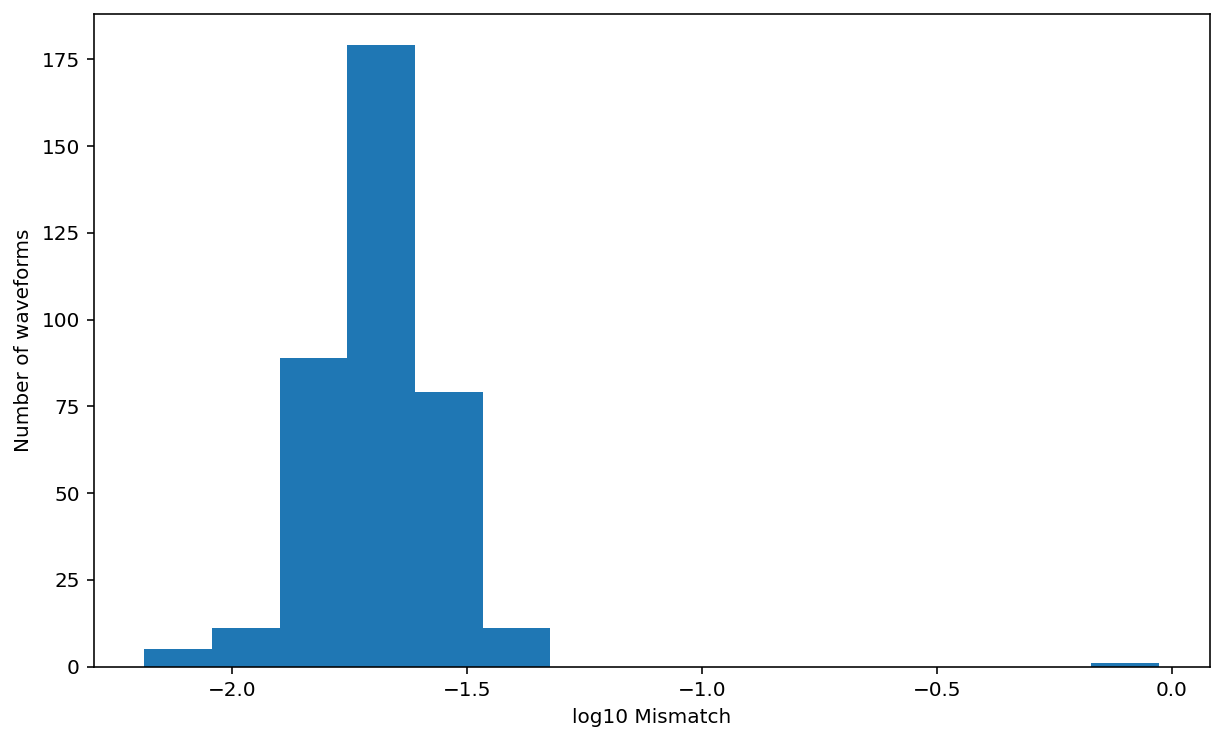

In [41]:
plt.figure(figsize=(10,6))

x,xx,xxx = plt.hist(np.log10(mismatches), bins=15)

plt.xlabel('log10 Mismatch')
plt.ylabel('Number of waveforms')
#plt.xscale('log')
plt.show()

In [42]:
np.median(mismatches), min(mismatches), max(mismatches)

(0.020576835391719284, 0.006514408542566463, 0.939656345062978)

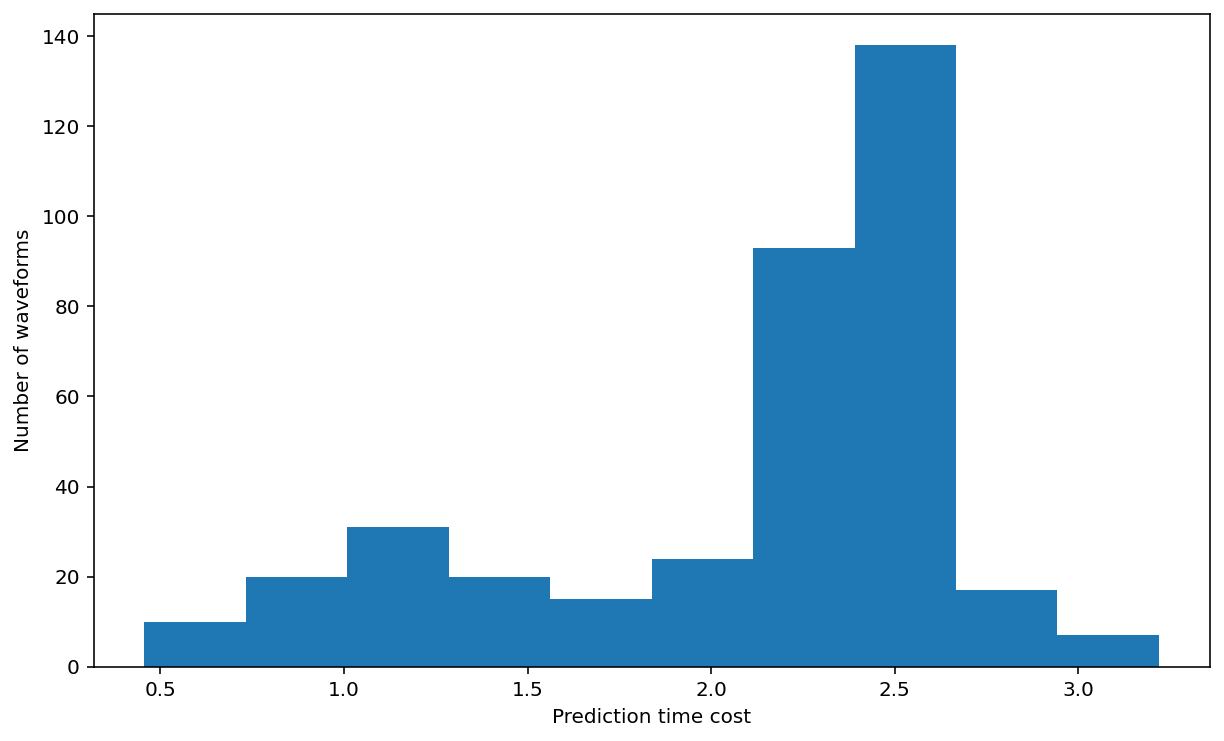

In [43]:
plt.figure(figsize=(10,6))

x,xx,xxx = plt.hist(predtimes)

plt.xlabel('Prediction time cost')
plt.ylabel('Number of waveforms')
plt.show()